<a href="https://colab.research.google.com/github/YonggunJung/colab/blob/main/1209DLotto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
win = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/로또/data/jlotto.csv', delimiter = ',')
win

array([[ 4.,  7., 17., 18., 38., 44.],
       [ 8., 12., 13., 29., 33., 42.],
       [ 3.,  7., 14., 15., 22., 38.],
       ...,
       [ 1.,  3., 17., 26., 27., 42.],
       [10., 22., 24., 27., 38., 45.],
       [ 6., 27., 30., 36., 38., 42.]])

In [4]:
xn = len(win)

In [5]:
# 숫자를 원핫 인코딩으로 변환
def n2o(numbers):

  oh = np.zeros(45)  # 45개의 빈 칸 만들기

  for i in range(6):            # 6개의 당첨번호를 반복
      oh[int(numbers[i])-1] = 1   # 번호는 1부터 시작하고 인덱스는 0부터 시작하니 1을 빼줌

  return oh

# 원핫 인코딩을 숫자로 변환
def o2n(oh):

  numbers = []

  for i in range(len(oh)):
    if oh[i] == 1:           # oh[i]이 1 이면 해당 번호를 출력
      numbers.append(i+1)    # 인덱스 보다 숫자가 1크니까 1더해줌 출력

  return numbers

In [6]:
numbers = win[: , :]  # 이게 문제라서 못 하겠음ㅠ 데이터 프레임이 문제인가?
                      # 데이터 프레임으로 안열고 넘파이 텍스트 파일로 가져오니 됨
ohs = list(map(n2o, numbers))

xs = ohs[0:xn -1]
ys = ohs[1:xn]

# 원핫 인코딩 확인
print('ohs')
print('x[0] :' + str(xs[0]))
print('y[0] :' + str(ys[0]))
print('x[마지막] :' + str(xs[-1]))
print('y[마지막] :' + str(ys[-1]))

# 번호 확인
print('numbers')
print('x[0] :' + str(o2n(xs[0])))
print('y[0] :' + str(o2n(ys[0])))
print('x[마지막] :' + str(o2n(xs[-1])))
print('y[마지막] :' + str(o2n(ys[-1])))

ohs
x[0] :[0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0.]
y[0] :[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
x[마지막] :[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
y[마지막] :[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
numbers
x[0] :[4, 7, 17, 18, 38, 44]
y[0] :[8, 12, 13, 29, 33, 42]
x[마지막] :[10, 22, 24, 27, 38, 45]
y[마지막] :[6, 27, 30, 36, 38, 42]


In [7]:
train = (0, int(len(win)*0.6))
val = (int(len(win)*0.6), int(len(win)*0.8))
test = (int(len(win)*0.8), len(win))

print('train : {0}, val : {1}, test : {2}'.format(train, val, test))

train : (0, 724), val : (724, 966), test : (966, 1208)


In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

# 모델 정의
model = keras.Sequential([
    keras.Input(batch_shape=(1, 1, 45)),   # ✅ 입력 형태는 여기서 정의
    layers.LSTM(128,
                return_sequences=False,
                stateful=True),
    layers.Dense(45, activation='sigmoid')
])

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [9]:
# 매 에포크마다 훈련과 검증의 손실 및 정확도를 기록하기 위한 변수
train_loss = []
train_acc = []
val_loss = []
val_acc = []

# 최대 100번 에포크까지 수행
for epoch in range(45):
    # model.reset_states()  ❌ (삭제)
    # 대신 개별 LSTM 레이어 상태 초기화
    for layer in model.layers:
        if hasattr(layer, 'reset_states'):
            layer.reset_states()

    batch_train_loss = []
    batch_train_acc = []

    for i in range(train[0], train[1]):

        xss = xs[i].reshape(1, 1, 45)
        yss = ys[i].reshape(1, 45)

        loss, acc = model.train_on_batch(xss, yss) # 배치만큼 모델에 학습

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val[0], val[1]):

        xss = xs[i].reshape(1, 1, 45)
        yss = ys[i].reshape(1, 45)

        loss, acc = model.test_on_batch(xss, yss) # 배치만큼 모델에 입력하여 나온 결과를 정답과 비교함

        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch{0:4d}, acc {1:0.3f}, loss {2: 0.3f}, val_acc {3:0.3f}, val_loss {4:0.3f}'.format(epoch,
                                                                                                  np.mean(batch_train_acc),
                                                                                                  np.mean(batch_train_loss),
                                                                                                  np.mean(batch_val_acc),
                                                                                                  np.mean(batch_val_loss)))

epoch   0, acc 0.009, loss  0.448, val_acc 0.010, val_loss 0.409
epoch   1, acc 0.011, loss  0.405, val_acc 0.012, val_loss 0.402
epoch   2, acc 0.012, loss  0.401, val_acc 0.013, val_loss 0.400
epoch   3, acc 0.014, loss  0.399, val_acc 0.015, val_loss 0.398
epoch   4, acc 0.016, loss  0.397, val_acc 0.018, val_loss 0.397
epoch   5, acc 0.018, loss  0.396, val_acc 0.020, val_loss 0.395
epoch   6, acc 0.021, loss  0.394, val_acc 0.024, val_loss 0.393
epoch   7, acc 0.025, loss  0.392, val_acc 0.027, val_loss 0.392
epoch   8, acc 0.028, loss  0.391, val_acc 0.030, val_loss 0.390
epoch   9, acc 0.031, loss  0.389, val_acc 0.032, val_loss 0.388
epoch  10, acc 0.034, loss  0.387, val_acc 0.035, val_loss 0.386
epoch  11, acc 0.037, loss  0.385, val_acc 0.038, val_loss 0.384
epoch  12, acc 0.039, loss  0.382, val_acc 0.041, val_loss 0.381
epoch  13, acc 0.042, loss  0.380, val_acc 0.043, val_loss 0.379
epoch  14, acc 0.044, loss  0.378, val_acc 0.046, val_loss 0.377
epoch  15, acc 0.047, los

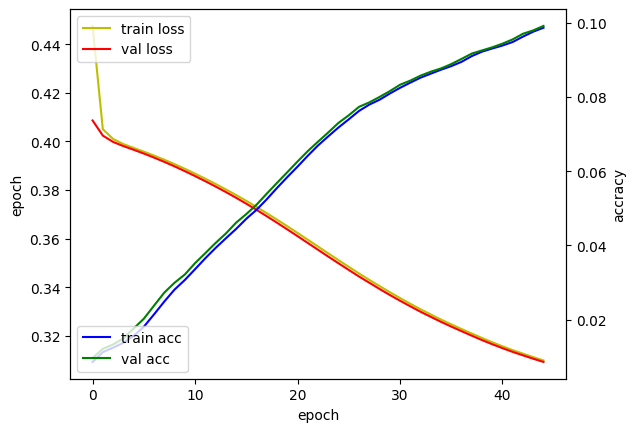

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label = 'train loss')
loss_ax.plot(val_loss, 'r', label = 'val loss')

acc_ax.plot(train_acc, 'b', label = 'train acc')
acc_ax.plot(val_acc, 'g', label = 'val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('epoch')
acc_ax.set_ylabel('accracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()
# 이미 학습은 의미가 없다는 결론이 나옴

In [11]:
# 모든 데이터를 학습용으로 사용
for epoch in range(45):

    # LSTM 레이어의 상태 초기화
    for layer in model.layers:
        if hasattr(layer, "reset_states"):
            layer.reset_states()

    batch_train_loss = []
    batch_train_acc = []

    for i in range(len(xs)):
        xss = xs[i].reshape(1, 1, 45)
        yss - ys[i].reshape(1, 45)

        loss, acc = model.train_on_batch(xss, yss)  # 배치 학습

        batch_train_loss.append(loss)
        batch_train_acc.append(acc)

    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    print("epoch{0:4d}, acc {1:0.3f}, loss {2:0.3f}".format(
        epoch,
        np.mean(batch_train_acc),
        np.mean(batch_train_loss)
    ))


epoch   0, acc 0.101, loss 0.307
epoch   1, acc 0.107, loss 0.299
epoch   2, acc 0.113, loss 0.291
epoch   3, acc 0.120, loss 0.283
epoch   4, acc 0.128, loss 0.276
epoch   5, acc 0.136, loss 0.270
epoch   6, acc 0.146, loss 0.263
epoch   7, acc 0.155, loss 0.257
epoch   8, acc 0.165, loss 0.252
epoch   9, acc 0.176, loss 0.246
epoch  10, acc 0.186, loss 0.241
epoch  11, acc 0.197, loss 0.236
epoch  12, acc 0.208, loss 0.231
epoch  13, acc 0.221, loss 0.226
epoch  14, acc 0.236, loss 0.222
epoch  15, acc 0.250, loss 0.217
epoch  16, acc 0.264, loss 0.213
epoch  17, acc 0.278, loss 0.209
epoch  18, acc 0.291, loss 0.205
epoch  19, acc 0.304, loss 0.202
epoch  20, acc 0.316, loss 0.198
epoch  21, acc 0.328, loss 0.195
epoch  22, acc 0.340, loss 0.191
epoch  23, acc 0.351, loss 0.188
epoch  24, acc 0.362, loss 0.185
epoch  25, acc 0.372, loss 0.182
epoch  26, acc 0.382, loss 0.179
epoch  27, acc 0.392, loss 0.176
epoch  28, acc 0.401, loss 0.174
epoch  29, acc 0.410, loss 0.171
epoch  30,

In [12]:
from datetime import date

# 다음회 예측

xss = xs[-1].reshape(1, 1, 45)

pred = model.predict_on_batch(xss)
pred

print(date.today())
print('receive numbers')
len(ohs)

luck = list(map(o2n, pred))
luck

# list_number = []

# for n in range(6):
#   numbers =pred
  # numbers.sort()
  # print('{0} : {1}'.format(n, numbers))
  # list_numbers.append(numbers)

2026-01-25
receive numbers


[[3, 11, 13, 14, 17, 21]]

In [13]:
[[3, 11, 13, 14, 17, 21]]

[[4, 6, 10, 11, 32, 37]]

In [14]:
# 100번 돌리나 35번 돌리나 결과는 똑같다.